## functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import gc

import addict
import lightgbm as lgb

def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)


def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)


def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)


def load_dataframe32(path, nrows=None):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    if nrows and nrows > 0:
        return result.head(nrows)
    return result

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
def replace_nan(X):
    X = X.copy()
    X[np.isnan(X)] = 0
    X[X == np.Inf] = X[X != np.Inf].max()
    X[X == -np.Inf] = X[X != -np.Inf].min()
    # print(X.shape, X.max(), X.min())
    return X

## check data

In [4]:
# nrows = None  
nrows = 1000

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)
    
    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    gc.collect()
    
    X_train = train_data.values
    X_valid = valid_data.values
    X_test = test_data.values
    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)
    
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape)
    

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(1000,) (1000,)
./neptune-features/data_246008_1174_0 (1000, 1174)
./neptune-features/data_61503_1174_1 (1000, 1174)
./neptune-features/data_48744_1174_3 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_4 (1000, 1174)
./neptune-features/data_61502_1174_5 (1000, 1174)
./neptune-features/data_48744_1174_7 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
./neptune-features/train_idx_2.npy ./neptune-features/valid_idx_2.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_8 (1000, 1174)
./neptune-features/data_61502_1174_9 (1000, 1174)
./neptune-features/data_48744_1174_11 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
./neptune-features/train_idx_3.npy ./neptune-features/valid_idx_3.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_1

## svm

In [11]:
svc_params = addict.Dict()
svc_params.C = 1.0
svc_params.kernel = "rbf"
svc_params.degree = 5
svc_params.gamma = "auto"
svc_params.coef0 = 0.0
svc_params.probability = False # True
svc_params.tol = 0.005  # 0.00001
svc_params.max_iter = -1
svc_params.max_iter = 12000

In [12]:
# nrows = None  
nrows = None
# nrows = 1000

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)
    
    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    gc.collect()
    
    X_train = replace_nan(train_data.values)
    X_valid = replace_nan(valid_data.values)
    X_test = replace_nan(test_data.values)
    
    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)
    
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape)
    
    estimator = make_pipeline(StandardScaler(), SVC(**svc_params))
    
    %time estimator.fit(X_train, y_train)
    
    pred_valid = estimator.decision_function(X_valid)
    pred_valid_stack.append(pred_valid)
    
    auc = roc_auc_score(y_valid, pred_valid)
    auc_valid_stack.append(auc)
    print("fold-{},auc:{}".format(i, auc))

    pred_test = estimator.decision_function(X_test)
    pred_test_stack.append(pred_test)
    
print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=12000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Wall time: 1h 53min 39s
fold-0,auc:0.6323481285051821
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_4 (246009, 1174)
./neptune-features/data_61502_1174_5 (61502, 1174)
./neptune-features/data_48744_1174_7 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=12000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Wall time: 1h 53min 59s
fold-1,auc:0.6586490776005468
./neptune-features/train_idx_2.npy ./neptune-features/valid_idx_2.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_8 (246009, 1174)
./neptune-features/data_61502_1174_9 (61502, 1174)
./neptune-features/data_48744_1174_11 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=12000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Wall time: 1h 53min 35s
fold-2,auc:0.6075495302998379
./neptune-features/train_idx_3.npy ./neptune-features/valid_idx_3.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_12 (246009, 1174)
./neptune-features/data_61502_1174_13 (61502, 1174)
./neptune-features/data_48744_1174_15 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=12000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Wall time: 1h 53min 35s
fold-3,auc:0.5678462789947946
./neptune-features/train_idx_4.npy ./neptune-features/valid_idx_4.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_16 (246009, 1174)
./neptune-features/data_61502_1174_17 (61502, 1174)
./neptune-features/data_48744_1174_19 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)


C:\Anaconda2\envs\python3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=12000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Wall time: 1h 54min 35s
fold-4,auc:0.6257566465265704
kfold-auc, avg:0.6184, std:0.03


fold-auc, avg:0.6573, std:0.038

## save oof & submission

In [27]:
def calculate_rank(predictions):
    rank = (1 + pd.Series(predictions).rank().values) / (predictions.shape[0] + 1)
    return rank

def save_submission(pred_valid_stack, pred_test_stack, train_app, seed=0, exp="031"):
    pred_fn = "./result/submission-{}-lgb-seed-{}.csv".format(exp, seed)
    oof_fn = "./oof-result/oof-{}-lgb-seed-{}.csv".format(exp, seed)
    pred_target = sum([calculate_rank(p_) for p_ in pred_test_stack]) / 5

    pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
    pred_sample["TARGET"] = pred_target
    pred_sample.to_csv(pred_fn, index=False)
    print("save:", pred_fn)

    oof_pred = np.zeros(train_app.shape[0])
    for i in range(5):
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)
        valid_idx = np.load(valid_idx_fn)
        oof_pred[valid_idx] = pred_valid_stack[i]

    oof_df = train_app[["SK_ID_CURR"]].copy()
    oof_df["SK_ID_CURR"] = oof_df.SK_ID_CURR.astype("int")
    oof_df["oof_pred"] = oof_pred
    oof_df.to_csv(oof_fn, index=False)
    print("save:", oof_fn)

## oof-avg

In [73]:
os.listdir("./oof-result/")

['oof-024-first.csv',
 'oof-024-keras01.csv',
 'oof-028-lgb.csv',
 'oof-029-keras.csv',
 'oof-030-keras01.csv',
 'oof-031-lgb-seed-0.csv',
 'oof-031-lgb-seed-1.csv',
 'oof-031-lgb-seed-10.csv',
 'oof-031-lgb-seed-11.csv',
 'oof-031-lgb-seed-12.csv',
 'oof-031-lgb-seed-13.csv',
 'oof-031-lgb-seed-14.csv',
 'oof-031-lgb-seed-15.csv',
 'oof-031-lgb-seed-16.csv',
 'oof-031-lgb-seed-17.csv',
 'oof-031-lgb-seed-18.csv',
 'oof-031-lgb-seed-19.csv',
 'oof-031-lgb-seed-2.csv',
 'oof-031-lgb-seed-20.csv',
 'oof-031-lgb-seed-21.csv',
 'oof-031-lgb-seed-22.csv',
 'oof-031-lgb-seed-23.csv',
 'oof-031-lgb-seed-24.csv',
 'oof-031-lgb-seed-25.csv',
 'oof-031-lgb-seed-26.csv',
 'oof-031-lgb-seed-27.csv',
 'oof-031-lgb-seed-28.csv',
 'oof-031-lgb-seed-29.csv',
 'oof-031-lgb-seed-3.csv',
 'oof-031-lgb-seed-4.csv',
 'oof-031-lgb-seed-5.csv',
 'oof-031-lgb-seed-6.csv',
 'oof-031-lgb-seed-7.csv',
 'oof-031-lgb-seed-8.csv',
 'oof-031-lgb-seed-9.csv']

In [55]:
oof_all = pd.DataFrame({
    "oof_{}".format(i): pd.read_csv("./oof-result/" + oof_fn).set_index("SK_ID_CURR").oof_pred
    for i, oof_fn in enumerate([
        'oof-024-first.csv',
        'oof-031-lgb-seed-0.csv',
        'oof-031-lgb-seed-1.csv',
        'oof-031-lgb-seed-2.csv',
        'oof-031-lgb-seed-3.csv',
        'oof-031-lgb-seed-4.csv',
        'oof-031-lgb-seed-5.csv',
        'oof-031-lgb-seed-6.csv',
        'oof-031-lgb-seed-7.csv',
        'oof-031-lgb-seed-8.csv',
        'oof-031-lgb-seed-9.csv'
    ])
})

train_app = load_dataframe32("./bindata/application_train")

oof_all["TARGET"] = train_app.set_index("SK_ID_CURR").TARGET

In [56]:
oof_all.head()

,oof_0,oof_1,oof_2,oof_3,oof_4,oof_5,oof_6,oof_7,oof_8,oof_9,oof_10,TARGET
SK_ID_CURR,,,,,,,,,,,,
100002,0.316064,0.270621,0.270621,0.270621,0.335002,0.299908,0.305175,0.307492,0.278590,0.254412,0.296260,1.0
100003,0.019087,0.017848,0.017848,0.017848,0.017131,0.017773,0.015755,0.017766,0.014906,0.017594,0.017002,0.0
100004,0.041876,0.042343,0.042343,0.042343,0.039920,0.038942,0.042403,0.040885,0.048782,0.045207,0.039214,0.0
100006,0.033489,0.028364,0.028364,0.028364,0.035470,0.033040,0.030226,0.034314,0.027817,0.028220,0.031818,0.0
100007,0.040865,0.049091,0.049091,0.049091,0.050078,0.043337,0.056284,0.045766,0.046031,0.040465,0.039917,0.0


In [60]:
oof_all.isnull().sum()

oof_0     0
oof_1     0
oof_2     0
oof_3     0
oof_4     0
oof_5     0
oof_6     0
oof_7     0
oof_8     0
oof_9     0
oof_10    0
TARGET    0
dtype: int64

In [59]:
oof_all.TARGET.value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [111]:
def rank_avg_and_show_oof_auc(oof_df, weights=None):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        # train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            #train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        # train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        
        fold_pred = np.zeros(fold_data.shape[0])
        
        columns = [col_ for col_ in oof_df.columns if col_ != "TARGET"]
        oof_size = len(columns)
        if weights is None:
            weights = np.ones(oof_size).astype("float") / oof_size
        else:
            weights = weights / weights.sum()
        for col_, w_ in zip(columns, weights):
            fold_pred += w_ * calculate_rank(oof_df.loc[valid_idx][col_])

        auc = roc_auc_score(fold_target, fold_pred)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

    print("kfold-auc, avg:{:.8}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

In [87]:
def calc_cv_auc(oof_df, col):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        # train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            #train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()
        # train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)
        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        auc = roc_auc_score(fold_target, fold_data[col])
        auc_valid_stack.append(auc)
    return np.mean(auc_valid_stack), np.std(auc_valid_stack)

In [64]:
rank_avg_and_show_oof_auc(oof_all.reset_index(drop=True))

fold-0,auc:0.7998100538713868
fold-1,auc:0.7932760820160709
fold-2,auc:0.7935870067425121
fold-3,auc:0.7950388520980503
fold-4,auc:0.793463110300679
kfold-auc, avg:0.79503502, std:0.0025


In [94]:
rank_avg_and_show_oof_auc(oof_all[better_columns + ["TARGET"]].reset_index(drop=True))

fold-0,auc:0.7997954908598757
fold-1,auc:0.793544816723948
fold-2,auc:0.793791729684066
fold-3,auc:0.7953916925349049
fold-4,auc:0.7938530446806475
kfold-auc, avg:0.79527535, std:0.0024


In [65]:
os.listdir("./result/")

['submission-022-blend08.csv',
 'submission-024-first.csv',
 'submission-025-avg-l88k12.csv',
 'submission-025-keras01.csv',
 'submission-028-avg-l08l79k13.csv',
 'submission-028-lgb.csv',
 'submission-029-keras.csv',
 'submission-030-bld-to-overfit',
 'submission-030-bld-to-overfit.csv',
 'submission-030-keras01-avg-025.csv',
 'submission-030-keras01.csv',
 'submission-031-lgb-seed-0.csv',
 'submission-031-lgb-seed-1.csv',
 'submission-031-lgb-seed-2.csv',
 'submission-031-lgb-seed-3.csv',
 'submission-031-lgb-seed-4.csv',
 'submission-031-lgb-seed-5.csv',
 'submission-031-lgb-seed-6.csv',
 'submission-031-lgb-seed-7.csv',
 'submission-031-lgb-seed-8.csv',
 'submission-031-lgb-seed-9.csv']

### better

In [74]:
oof_files = [
    'oof-024-first.csv',
    'oof-031-lgb-seed-0.csv',
    'oof-031-lgb-seed-1.csv',
    'oof-031-lgb-seed-10.csv',
    'oof-031-lgb-seed-11.csv',
    'oof-031-lgb-seed-12.csv',
    'oof-031-lgb-seed-13.csv',
    'oof-031-lgb-seed-14.csv',
    'oof-031-lgb-seed-15.csv',
    'oof-031-lgb-seed-16.csv',
    'oof-031-lgb-seed-17.csv',
    'oof-031-lgb-seed-18.csv',
    'oof-031-lgb-seed-19.csv',
    'oof-031-lgb-seed-2.csv',
    'oof-031-lgb-seed-20.csv',
    'oof-031-lgb-seed-21.csv',
    'oof-031-lgb-seed-22.csv',
    'oof-031-lgb-seed-23.csv',
    'oof-031-lgb-seed-24.csv',
    'oof-031-lgb-seed-25.csv',
    'oof-031-lgb-seed-26.csv',
    'oof-031-lgb-seed-27.csv',
    'oof-031-lgb-seed-28.csv',
    'oof-031-lgb-seed-29.csv',
    'oof-031-lgb-seed-3.csv',
    'oof-031-lgb-seed-4.csv',
    'oof-031-lgb-seed-5.csv',
    'oof-031-lgb-seed-6.csv',
    'oof-031-lgb-seed-7.csv',
    'oof-031-lgb-seed-8.csv',
    'oof-031-lgb-seed-9.csv'
]


oof_all = pd.DataFrame({
    "oof_{}".format(i): pd.read_csv("./oof-result/" + oof_fn).set_index("SK_ID_CURR").oof_pred
    for i, oof_fn in enumerate(oof_files)
})

train_app = load_dataframe32("./bindata/application_train")

oof_all["TARGET"] = train_app.set_index("SK_ID_CURR").TARGET
rank_avg_and_show_oof_auc(oof_all.reset_index(drop=True))

fold-0,auc:0.7998158872694663
fold-1,auc:0.7934690275193597
fold-2,auc:0.793654881978829
fold-3,auc:0.7951447849184524
fold-4,auc:0.7937091486809136
kfold-auc, avg:0.79515875, std:0.0024


In [92]:
better_columns = []
for i, fn in enumerate(oof_files):
    col_ = "oof_{}".format(i)
    cv_auc, cv_std = calc_cv_auc(oof_all.reset_index(), col_)
    print("{:35}, {:8}, {:.5}, {:.4}".format(fn, col_, cv_auc, cv_std))
    if cv_auc >= 0.7945:
        better_columns.append(col_)

oof-024-first.csv                  , oof_0   , 0.79453, 0.002204
oof-031-lgb-seed-0.csv             , oof_1   , 0.79426, 0.002599
oof-031-lgb-seed-1.csv             , oof_2   , 0.79426, 0.002599
oof-031-lgb-seed-10.csv            , oof_3   , 0.79446, 0.002332
oof-031-lgb-seed-11.csv            , oof_4   , 0.79442, 0.002256
oof-031-lgb-seed-12.csv            , oof_5   , 0.79457, 0.002379
oof-031-lgb-seed-13.csv            , oof_6   , 0.79451, 0.002476
oof-031-lgb-seed-14.csv            , oof_7   , 0.79454, 0.002633
oof-031-lgb-seed-15.csv            , oof_8   , 0.79453, 0.002396
oof-031-lgb-seed-16.csv            , oof_9   , 0.79414, 0.002331
oof-031-lgb-seed-17.csv            , oof_10  , 0.79441, 0.002233
oof-031-lgb-seed-18.csv            , oof_11  , 0.79458, 0.002444
oof-031-lgb-seed-19.csv            , oof_12  , 0.79447, 0.002104
oof-031-lgb-seed-2.csv             , oof_13  , 0.79426, 0.002599
oof-031-lgb-seed-20.csv            , oof_14  , 0.7943, 0.002261
oof-031-lgb-seed-21.csv   

In [95]:
test_all = pd.DataFrame({
    "pred_{}".format(i): pd.read_csv("./result/" + oof_fn.replace("oof", "submission")).set_index("SK_ID_CURR").TARGET
    for i, oof_fn in enumerate(oof_files)
})

test_all.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.454959,0.447619,0.447619,0.422952,0.447287,0.421024,0.430932,0.452137,0.433952,0.450586,...,0.412945,0.433796,0.437928,0.450836,0.426017,0.437083,0.440464,0.436078,0.452104,0.463646
100005,0.825939,0.825582,0.825582,0.839229,0.838129,0.818139,0.825090,0.806491,0.829283,0.811472,...,0.819292,0.848296,0.830067,0.827609,0.828713,0.828881,0.833160,0.835737,0.839856,0.841018
100013,0.336125,0.359930,0.359930,0.418619,0.358880,0.365777,0.348348,0.369593,0.355425,0.365211,...,0.376219,0.335850,0.350600,0.374549,0.416330,0.360324,0.376736,0.375998,0.367135,0.372231
100028,0.478145,0.500359,0.500359,0.470822,0.498086,0.485999,0.503695,0.462829,0.493950,0.499108,...,0.503075,0.460950,0.499657,0.502201,0.463317,0.478769,0.498357,0.510436,0.467412,0.477345
100038,0.861372,0.871909,0.871909,0.879893,0.877633,0.874490,0.877358,0.872364,0.877025,0.871310,...,0.865135,0.883504,0.876135,0.871174,0.880960,0.889076,0.885818,0.869480,0.866953,0.878543


In [97]:
better_columns

['oof_0',
 'oof_5',
 'oof_6',
 'oof_7',
 'oof_8',
 'oof_11',
 'oof_15',
 'oof_18',
 'oof_26',
 'oof_29']

In [98]:
pd.DataFrame({"TARGET": test_all[[col_.replace("oof", "pred") for col_ in better_columns]].sum(axis=1) / len(better_columns)}).to_csv("./result/submission-031-lgb-reorder-better10.csv")

In [96]:
len(better_columns)

10

### logistic

In [99]:
oof_all.head()

,oof_0,oof_1,oof_2,oof_3,oof_4,oof_5,oof_6,oof_7,oof_8,oof_9,...,oof_22,oof_23,oof_24,oof_25,oof_26,oof_27,oof_28,oof_29,oof_30,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.316064,0.270621,0.270621,0.282062,0.302840,0.290954,0.267564,0.281214,0.256711,0.273407,...,0.290900,0.298510,0.335002,0.299908,0.305175,0.307492,0.278590,0.254412,0.296260,1.0
100003,0.019087,0.017848,0.017848,0.015439,0.015332,0.018758,0.018760,0.015686,0.017824,0.016988,...,0.016799,0.020179,0.017131,0.017773,0.015755,0.017766,0.014906,0.017594,0.017002,0.0
100004,0.041876,0.042343,0.042343,0.047114,0.041685,0.039045,0.044342,0.046883,0.043431,0.048466,...,0.043337,0.040910,0.039920,0.038942,0.042403,0.040885,0.048782,0.045207,0.039214,0.0
100006,0.033489,0.028364,0.028364,0.036264,0.032824,0.032269,0.031154,0.035245,0.033644,0.027894,...,0.031119,0.034615,0.035470,0.033040,0.030226,0.034314,0.027817,0.028220,0.031818,0.0
100007,0.040865,0.049091,0.049091,0.047562,0.050200,0.043835,0.046983,0.054442,0.052506,0.043982,...,0.052550,0.049939,0.050078,0.043337,0.056284,0.045766,0.046031,0.040465,0.039917,0.0


In [101]:
oof_all.columns[:-1]

Index(['oof_0', 'oof_1', 'oof_2', 'oof_3', 'oof_4', 'oof_5', 'oof_6', 'oof_7',
       'oof_8', 'oof_9', 'oof_10', 'oof_11', 'oof_12', 'oof_13', 'oof_14',
       'oof_15', 'oof_16', 'oof_17', 'oof_18', 'oof_19', 'oof_20', 'oof_21',
       'oof_22', 'oof_23', 'oof_24', 'oof_25', 'oof_26', 'oof_27', 'oof_28',
       'oof_29', 'oof_30'],
      dtype='object')

In [125]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=10)

features = oof_all.columns[:-1].copy()

while 1:
    temp = oof_all[features].rank(axis=0) / 307512
    clf.fit(temp.values, oof_all.TARGET)
    effective = clf.coef_[0] > 0
    if features.shape[0] == effective.sum():
        break
    features = features[effective].copy()


In [126]:
features

Index(['oof_0', 'oof_3', 'oof_5', 'oof_6', 'oof_7', 'oof_8', 'oof_11',
       'oof_12', 'oof_15', 'oof_18', 'oof_20', 'oof_21', 'oof_24', 'oof_25',
       'oof_26', 'oof_29'],
      dtype='object')

In [127]:
clf.coef_[0]

array([0.22369432, 0.0562735 , 0.37515959, 0.17624539, 0.38004249,
       0.31044339, 0.33587079, 0.10728696, 0.78440301, 0.32031739,
       0.17009402, 0.11203265, 0.10407195, 0.12647844, 0.49191713,
       0.48239183])

In [128]:
rank_avg_and_show_oof_auc(oof_all[list(features) + ["TARGET"]].reset_index(), clf.coef_[0])

fold-0,auc:0.7988677436669157
fold-1,auc:0.792439451062366
fold-2,auc:0.7927587279376315
fold-3,auc:0.7946383194486206
fold-4,auc:0.7934326603147231
kfold-auc, avg:0.79442738, std:0.0023


In [66]:
test_all = pd.DataFrame({
    "pred_{}".format(i): pd.read_csv("./result/" + oof_fn.replace("oof", "submission")).set_index("SK_ID_CURR").TARGET
    for i, oof_fn in enumerate([
        'oof-024-first.csv',
        'oof-031-lgb-seed-0.csv',
        'oof-031-lgb-seed-1.csv',
        'oof-031-lgb-seed-2.csv',
        'oof-031-lgb-seed-3.csv',
        'oof-031-lgb-seed-4.csv',
        'oof-031-lgb-seed-5.csv',
        'oof-031-lgb-seed-6.csv',
        'oof-031-lgb-seed-7.csv',
        'oof-031-lgb-seed-8.csv',
        'oof-031-lgb-seed-9.csv'
    ])
})

test_all.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10
SK_ID_CURR,,,,,,,,,,,
100001,0.454959,0.447619,0.447619,0.447619,0.450836,0.426017,0.437083,0.440464,0.436078,0.452104,0.463646
100005,0.825939,0.825582,0.825582,0.825582,0.827609,0.828713,0.828881,0.833160,0.835737,0.839856,0.841018
100013,0.336125,0.359930,0.359930,0.359930,0.374549,0.416330,0.360324,0.376736,0.375998,0.367135,0.372231
100028,0.478145,0.500359,0.500359,0.500359,0.502201,0.463317,0.478769,0.498357,0.510436,0.467412,0.477345
100038,0.861372,0.871909,0.871909,0.871909,0.871174,0.880960,0.889076,0.885818,0.869480,0.866953,0.878543


In [71]:
pd.DataFrame({"TARGET": test_all.sum(axis=1) / 11}).to_csv("./result/submission-031-lgb-reorder-first2seed9.csv")

## compare

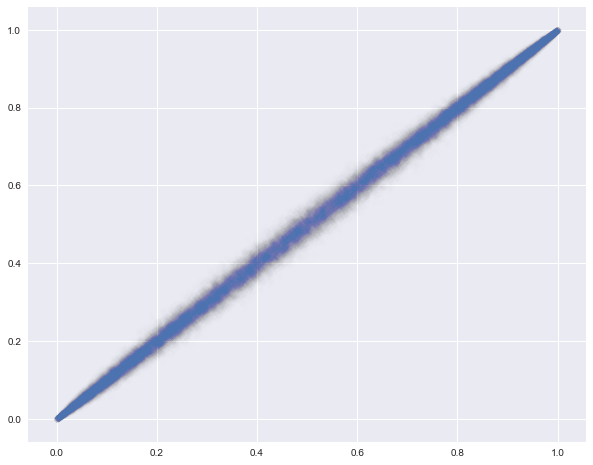

In [38]:
pred24f = pd.read_csv("./result/submission-024-first.csv")
pred31s0 = pd.read_csv("./result/submission-031-lgb-seed-0.csv")

plt.figure(figsize=(10, 8))
plt.scatter(pred24f.TARGET, pred31s0.TARGET, alpha=.005)
plt.show()

## blend

In [130]:
pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_lgbavg = pd.read_csv("./result/submission-030-bld-to-overfit.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")
pred_bld = pd.read_csv("./result/submission-022-blend08.csv")
pred_keras_avg = pd.read_csv("./result/submission-030-keras01-avg-025.csv")

pred_sample["TARGET"] = calculate_rank(pred_lgbavg.TARGET) * 0.8 + calculate_rank(pred_bld.TARGET) * 0.15 + calculate_rank(pred_keras_avg.TARGET) * 0.05
pred_sample.to_csv("./result/submission-031-bld-to-overfit.csv", index=False)

In [131]:
pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_lgbavg = pd.read_csv("./result/submission-030-bld-to-overfit.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")
pred_bld = pd.read_csv("./result/submission-022-blend08.csv")
pred_keras_avg = pd.read_csv("./result/submission-030-keras01-avg-025.csv")

pred_sample["TARGET"] = calculate_rank(pred_lgbavg.TARGET) * 0.75 + calculate_rank(pred_bld.TARGET) * 0.15 + calculate_rank(pred_keras_avg.TARGET) * 0.1
pred_sample.to_csv("./result/submission-031-bld-to-overfit75.csv", index=False)